In [1]:
import fitsio as fio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib as matplotlib

In [2]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_fmasked.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_fmasked.fits')[-1] # Satellite p_mem >= 0.2 catalog
clus = fio.FITS('/lsst/troxel/y1a1/lgt20_cluster_p20_fmasked.fits')[-1] # Cluster catalog
quad_pa = fio.FITS('/lsst/troxel/y1a1/lgt20_clus_ang_quad.fits')[-1]
cent_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20_im3shape.fits')[-1]
sat_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20_im3shape.fits')[-1]
clus_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_cluster_p20_im3shape.fits')[-1]
quad_pa_3 = fio.FITS('/lsst/troxel/y1a1/lgt20_clus_ang_quad_3.fits')[-1]

In [3]:
def sat_num(sat=sat.read()):
    sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'], return_counts=True)
    clus_n = len(sat_id_unq)
    sat_max = np.amax(counts)
    
    return sat_id_unq, counts, clus_n, sat_max

In [4]:
sat_id_unq, counts, clus_n, sat_max = sat_num()

In [5]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop, sat=sat.read()):
    sat_id_unq, counts, clus_n, sat_max = sat_num(sat)
    sat_prop_full = sat[prop]
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [6]:
# Create 2D array for specified property of all satellite galaxies
def sat_mag(band, sat=sat.read()):
    sat_id_unq, counts, clus_n, sat_max = sat_num(sat)
    sat_prop_full = sat['MODEL_MAG'][:,band]
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [7]:
# Calculate satellite angular position for all clusters
def sat_ang_pos(cent=cent.read(), sat=sat.read()):
    clus_n = sat_num(sat)[2]
    sat_ra = np.radians(sat_prop('RA', sat))
    sat_dec = np.radians(sat_prop('DEC', sat))
    cent_ra = np.radians(cent['RA'].reshape((clus_n,-1)))
    cent_dec = np.radians(cent['DEC'].reshape((clus_n,-1)))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [8]:
def mom_2(p, x, y, a, b):
    mom_top = p*a*b/(x**2+y**2)
    mom_sum = np.sum(np.nan_to_num(mom_top), axis=1)/np.sum(np.nan_to_num(p), axis=1)
    
    return mom_sum

In [9]:
def clus_pa(cent=cent.read(), sat=sat.read()):
    sat_ang = sat_ang_pos(cent, sat)
    p_i = sat_prop('P', sat) * sat_prop('PFREE', sat)
    x_i = sat_prop('R', sat) * np.cos(sat_ang)
    y_i = sat_prop('R', sat) * np.sin(sat_ang)
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    Q = m_xx - m_yy
    U = 2 * m_xy
    beta = np.arctan2(U, Q) / 2
    e = np.sqrt(Q**2 + U**2)
    
    return beta

In [10]:
clus_ang = clus_pa()

In [11]:
np.rad2deg(clus_ang[2560])

47.898435441033264

In [12]:
def clus_e(cent=cent.read(), sat=sat.read()):
    sat_ang = sat_ang_pos(cent, sat)
    p_i = sat_prop('P', sat) * sat_prop('PFREE', sat)
    x_i = sat_prop('R', sat) * np.cos(sat_ang)
    y_i = sat_prop('R', sat) * np.sin(sat_ang)
    m_xx = mom_2(p_i, x_i, y_i, x_i, x_i)
    m_xy = mom_2(p_i, x_i, y_i, x_i, y_i)
    m_yy = mom_2(p_i, x_i, y_i, y_i, y_i)
    Q = m_xx - m_yy
    U = 2 * m_xy
    beta = np.arctan2(U, Q) / 2
    e = np.sqrt(Q**2 + U**2)
    
    return e

In [13]:
clus_elip = clus_e()

In [14]:
cluse_sort = np.argsort(clus_elip)

In [15]:
def clus_shape(clus_id):
    cent_mask = cent['MEM_MATCH_ID'].read()==clus_id
    cluselip = clus_elip[cent_mask]
    cluspa = np.rad2deg(clus_ang[cent_mask])
    clus_data = clus.read()[cent_mask]
    
    return cluselip, cluspa, clus_data

In [16]:
clus_shape(5287)

(array([0.73025976]),
 array([47.89843544]),
 array([(5287, 89.115345, -47.538045, [21.472307, 19.678291, 19.093794, 18.755186], [0.02154457, 0.00854855, 0.00870567, 0.00951756], 18.755186, 0.00951756, 0.41582534, 0.02001608, 0.917051, -1., -1., 0.42412716, 0.41284013, 23.17652, 2.0170834, 22.169691, 2.1267478, 0.7464653, 1.010004, 0.01238029, 0., [2.5304503 , 0.75005835, 0.40790412], [0.00160562, 0.00040321, 0.00044544], [0.00140799, 0.00019688, 0.00019844, 0.        ], 0.8698218, 0.4138089, 0.01542941, 10, 0., 33.07642, 0.17644274, 33.25286, [0.3272189 , 0.3358779 , 0.3445369 , 0.3531959 , 0.3618549 , 0.37051392, 0.37917292, 0.38783193, 0.39649093, 0.40514994, 0.41380894, 0.42246795, 0.4311269 , 0.4397859 , 0.4484449 , 0.4571039 , 0.4657629 , 0.47442192, 0.48308092, 0.49173993, 0.50039893], [1.5980352e-07, 8.3660179e-06, 2.5049495e-04, 4.7396822e-03, 5.2713510e-02, 3.9235094e-01, 1.8631766e+00, 6.0396504e+00, 1.3823457e+01, 2.2153851e+01, 2.5869892e+01, 2.2154003e+01, 1.3894474e+01, 

In [17]:
def get_clus(clus_id, radec=False):
    sat_mask = sat['MEM_MATCH_ID'].read()==clus_id
    clus_sats = sat.read()[sat_mask]
    cent_mask = cent['MEM_MATCH_ID'].read()==clus_id
    clus_cent = cent.read()[cent_mask]
    if radec:
        
        return clus_cent['RA'], clus_cent['DEC']
    else:
        
        return clus_cent, clus_sats

In [18]:
def clus_plot(cent_ra, cent_dec, sats_ra, sats_dec):
    plt.scatter(sats_ra-cent_ra, sats_dec-cent_dec)
    plt.show()
    
    return

In [19]:
def clus_getplot(clus_id):
    cent_got, sats_got = get_clus(clus_id)
    ra_cent = cent_got['RA']
    dec_cent = cent_got['DEC']
    ra_sats = sats_got['RA']
    dec_sats = sats_got['DEC']
    clus_plot(ra_cent, dec_cent, ra_sats, dec_sats)
    
    return

In [20]:
# Calculate position angle
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1) / 2
    
    return alpha

In [21]:
def clus_align_ang(cent=cent.read(), sat=sat.read(), pa=False):
    if pa is not False:
        clus_ang = pa
    else:
        clus_ang = clus_pa(cent, sat)
    cent_ang = pos_ang(cent['e1'], cent['e2'])
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

In [22]:
cente = np.sqrt((cent['e1'].read())**2 + (cent['e2'].read()**2))

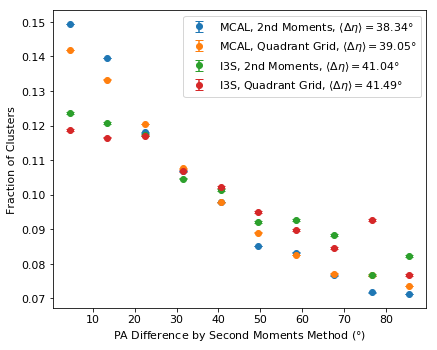

In [23]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_ang()
quad_align = clus_align_ang(pa=quad_pa.read())
clus_align_3 = clus_align_ang(cent_3.read(), sat_3.read())
quad_align_3 = clus_align_ang(cent=cent_3.read(), sat=sat_3.read(), pa=quad_pa_3.read())
matplotlib.rcParams.update({'font.size': 11}) # before plotting coode
plt.figure(figsize=(6.2,5))
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/np.sum(n), yerr=new_array/np.sum(n), fmt='o', capsize=4, label=fr'MCAL, 2nd Moments, $\langle \Delta \eta \rangle = {np.sum(clus_align)/np.sum(n):.2f}\degree$')
n, bins = np.histogram(quad_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = quad_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/np.sum(n), yerr=new_array/np.sum(n), fmt='o', capsize=4, label=fr'MCAL, Quadrant Grid, $\langle \Delta \eta \rangle = {np.sum(quad_align)/np.sum(n):.2f}\degree$')
n, bins = np.histogram(clus_align_3, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align_3[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/np.sum(n), yerr=new_array/np.sum(n), fmt='o', capsize=4, label=fr'I3S, 2nd Moments, $\langle \Delta \eta \rangle = {np.sum(clus_align_3)/np.sum(n):.2f}\degree$')
n, bins = np.histogram(quad_align_3, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = quad_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/np.sum(n), yerr=new_array/np.sum(n), fmt='o', capsize=4, label=fr'I3S, Quadrant Grid, $\langle \Delta \eta \rangle = {np.sum(quad_align_3)/np.sum(n):.2f}\degree$')
plt.xlabel(r'PA Difference by Second Moments Method ($\degree$)')
plt.ylabel('Fraction of Clusters')
plt.legend()
plt.tight_layout()
plt.savefig('/lsst/troxel/y1a1/plots/padif_methods_catalogs.pdf', bbox_inches='tight')

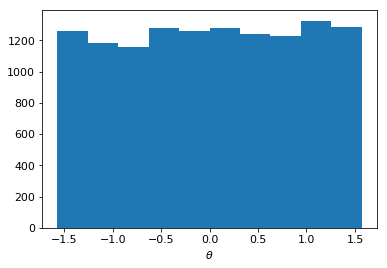

In [24]:
clus_ang = clus_pa()
plt.hist(clus_ang)
plt.xlabel(r'$\theta$')
plt.show()

In [25]:
#fio.write('/lsst/troxel/y1a1/lgt20_clus_ang_2mom.fits', clus_ang, clobber=True)

In [26]:
def clus_iter(prop, minimum, maximum, bins):
    bin_size = (maximum - minimum) / bins
    cents = []
    sats = []
    for i in range(bins):
        cent_mask = np.logical_and(np.less_equal(minimum + i*bin_size, prop), np.less_equal(prop, minimum + (i+1)*bin_size))
        cents.append(cent.read()[cent_mask])
        sat_mask = np.in1d(sat['MEM_MATCH_ID'].read(), cents[i]['MEM_MATCH_ID'], assume_unique=False)
        sats.append(sat.read()[sat_mask])
    
    return cents, sats

In [27]:
def clus_iter2(prop, bins):
    prop_sort = np.argsort(prop)
    prop_sorted = prop[prop_sort]
    bin_edges = prop_sorted[::clus_n//bins]
    cents = []
    sats = []
    for i in range(bins):
        cent_mask = np.logical_and(np.less_equal(bin_edges[i], prop), np.less_equal(prop, bin_edges[i+1]))
        cents.append(cent.read()[cent_mask])
        sat_mask = np.in1d(sat['MEM_MATCH_ID'].read(), cents[i]['MEM_MATCH_ID'], assume_unique=False)
        sats.append(sat.read()[sat_mask])
    
    return cents, sats, bin_edges

In [28]:
def align_iter(cent_cats, sat_cats):
    aligns = []
    means = []
    for i in range(len(cent_cats)):
        sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
        aligns.append(clus_align_ang(cent_cats[i], sat_cats[i]))
        means.append(np.sum(aligns[i])/clus_n)
    
    return aligns, means

In [29]:
def plot_iter(cent_cats, sat_cats):
    for i in range(len(cent_cats)):
        if len(cent_cats[i]) > 250:
            # Plot histogram of cluster alignment angle (with standard error of the mean)
            sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
            clus_align = clus_align_ang(cent=cent_cats[i], sat=sat_cats[i])
            n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
            k = 0
            new_array = np.zeros(10)
            for i in range(10):
                bin_i = clus_align[k:k+n[i]]
                std_i = np.std(bin_i)
                sem_i = std_i/np.sqrt(n[i])
                new_array[i] = sem_i
                k = k + n[i]
            plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, capsize=4)
            plt.xlabel(r'PA Difference ($\degree$)')
            plt.ylabel('Fraction of Clusters')
            plt.text(10, 0.05, str(clus_n))
            plt.xlim(0, 90)
            plt.ylim(0., 0.25)
            f = plt.gcf()
            f.set_size_inches(5., 4.)
            print(np.sum(clus_align)/clus_n)
            plt.show()
    
    return 1

In [66]:
def plot_iter2(cent_cats, sat_cats, bin_edges, prop, title, filename=''):
    matplotlib.rcParams.update({'font.size': 11}) # before plotting coode
    plt.figure(figsize=(6.2,5))
    for i in range(len(cent_cats)):
        if len(cent_cats[i]) > 250:
            # Plot histogram of cluster alignment angle (with standard error of the mean)
            sat_id_unq, counts, clus_n, sat_max = sat_num(sat_cats[i])
            clus_align = clus_align_ang(cent=cent_cats[i], sat=sat_cats[i])
            n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
            k = 0
            new_array = np.zeros(10)
            for j in range(10):
                bin_i = clus_align[k:k+n[j]]
                std_i = np.std(bin_i)
                sem_i = std_i/np.sqrt(n[j])
                new_array[j] = sem_i
                k = k + n[j]
            plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, capsize=4, fmt='o', label=fr'{bin_edges[i]:.2f} < {prop} < {bin_edges[i+1]:.2f}, $\langle \Delta \eta \rangle = {np.sum(clus_align)/clus_n:.2f}\degree$')
            plt.xlabel(r'PA Difference ($\degree$)')
            plt.ylabel('Fraction of Clusters')
            plt.title(title)
            plt.legend()
            #plt.xlim(0, 90)
            #plt.ylim(0., 0.25)
            #f = plt.gcf()
            #f.set_size_inches(5., 4.)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    
    return

In [31]:
cent_z, sat_z = clus_iter(cent['Z'].read(), np.min(cent['Z'].read()), np.max(cent['Z'].read()), 3)

In [32]:
cent_z2, sat_z2, z_edges = clus_iter2(cent['Z'].read(), 3)

In [33]:
cent_e, sat_e = clus_iter(clus_elip, np.min(clus_elip), np.max(clus_elip), 10)

In [34]:
cent_lambda, sat_lambda = clus_iter(np.log10(clus['LAMBDA_CHISQ'].read()), np.min(np.log10(clus['LAMBDA_CHISQ'].read())), np.max(np.log10(clus['LAMBDA_CHISQ'].read())), 3)

In [35]:
cent_lambda2, sat_lambda2, lambda_edges = clus_iter2(np.log10(clus['LAMBDA_CHISQ'].read()), 3)

In [36]:
cent_cente, sat_cente = clus_iter(cente, np.min(cente), np.max(cente), 10)

In [37]:
cent_pcen, sat_pcen = clus_iter(clus['P_CEN'].read()[:,0], np.min(clus['P_CEN'].read()[:,0]), np.max(clus['P_CEN'].read()[:,0]), 10)

In [38]:
cent_rmag, sat_rmag = clus_iter(cent['MODEL_MAG'].read()[:, 1], np.min(cent['MODEL_MAG'].read()[:, 1]), np.max(cent['MODEL_MAG'].read()[:, 1]), 10)

In [39]:
cent_rmag2, sat_rmag2, rmag_edges = clus_iter2(cent['MODEL_MAG'].read()[:,1], 3)

In [40]:
cent_lum, sat_lum = clus_iter(clus['BCG_ZLUM'].read(), np.min(clus['BCG_ZLUM'].read()), np.max(clus['BCG_ZLUM'].read()), 10)

In [41]:
gr = cent['MODEL_MAG'].read()[:,0] - cent['MODEL_MAG'].read()[:,1]
cent_gr, sat_gr = clus_iter(gr, np.min(gr), np.max(gr), 3)

In [42]:
cent_gr2, sat_gr2, gr_edges = clus_iter2(gr, 3)

In [64]:
def dom():
    dom = np.zeros((clus_n))
    for i in range(clus_n):
        sats_mask = sat['MEM_MATCH_ID'].read()==cent['MEM_MATCH_ID'].read()[i]
        sats_mag = sat['MODEL_MAG'].read()[:,1][sats_mask]
        mag_sort = np.argsort(sats_mag)
        avg = (sats_mag[mag_sort[-1]]+sats_mag[mag_sort[-2]]) / 2
        dom[i] = cent['MODEL_MAG'].read()[:,1][i] - avg
    
    return dom

In [73]:
cg_dom = dom()

In [74]:
cent_dom2, sat_dom2, dom_edges = clus_iter2(cg_dom, 3)

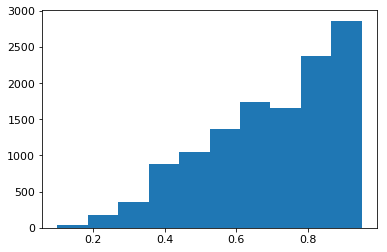

In [49]:
plt.hist(cent['Z'].read())
plt.show()

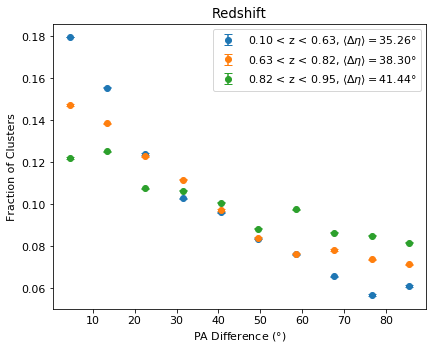

In [68]:
plot_iter2(cent_z2, sat_z2, z_edges, 'z', 'Redshift', '/lsst/troxel/y1a1/plots/padif_2mom_redshift.pdf')

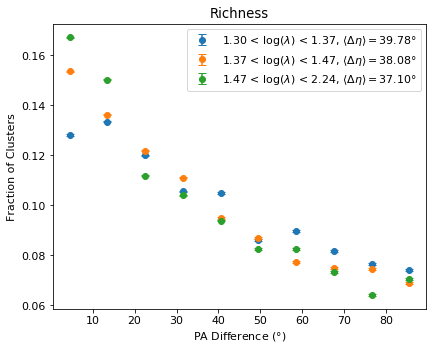

In [70]:
plot_iter2(cent_lambda2, sat_lambda2, lambda_edges, '$\log(\lambda)$', 'Richness', '/lsst/troxel/y1a1/plots/padif_2mom_lambda.pdf')

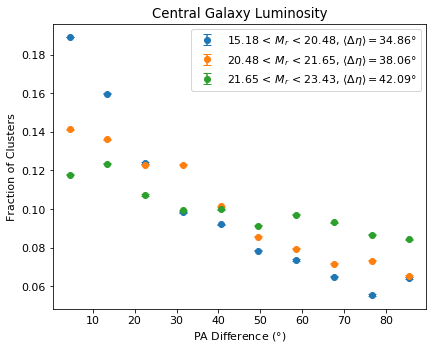

In [71]:
plot_iter2(cent_rmag2, sat_rmag2, rmag_edges, '$M_r$', 'Central Galaxy Luminosity', '/lsst/troxel/y1a1/plots/padif_2mom_Mr.pdf')

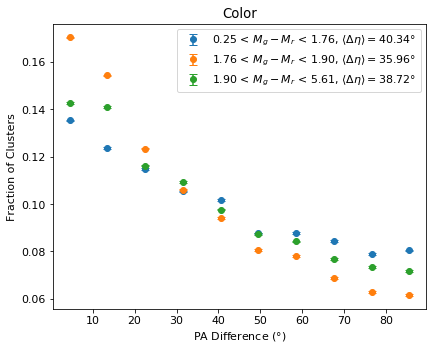

In [72]:
plot_iter2(cent_gr2, sat_gr2, gr_edges, '$M_g-M_r$', 'Color', '/lsst/troxel/y1a1/plots/padif_2mom_color.pdf')

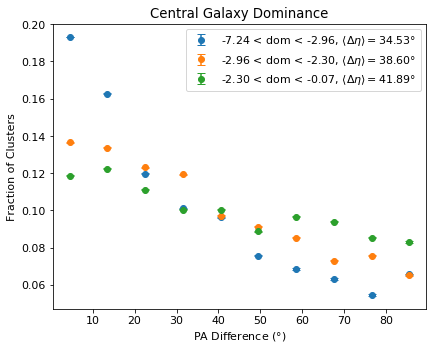

In [75]:
plot_iter2(cent_dom2, sat_dom2, dom_edges, 'dom', 'Central Galaxy Dominance', '/lsst/troxel/y1a1/plots/padif_2mom_dom.pdf')